Preamble here:

In [ ]:
#NeuroDiffEq can be used without running this cell. This is for loading Julia and installing/importing PySR for an example at the end.
try:
    import pysr

except ImportError:
    import subprocess
    import sys

    print("Installing Julia and PySR. This might take some time...")

    shell_script = '''
    # @title Install Julia and PySR (Takes some time)
    %%shell
    set -e

    #---------------------------------------------------#
    JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
    JULIA_PACKAGES="IJulia BenchmarkTools"
    JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
    JULIA_NUM_THREADS=2
    #---------------------------------------------------#

    if [ -z `which julia` ]; then
        # Install Julia
        JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
        echo "Installing Julia $JULIA_VERSION..."
        BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
        URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
        wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
        tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
        rm /tmp/julia.tar.gz

        # Install Packages
        nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
        if [ $GPU -eq 1 ]; then
        JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
        fi
        for PKG in `echo $JULIA_PACKAGES`; do
        echo "Installing Julia package $PKG..."
        julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
        done

        # Install kernel and rename it to "julia"
        echo "Installing IJulia kernel..."
        julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
            "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
        KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
        KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
        mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

        echo ''
        echo "Successfully installed `julia -v`!"
    fi
    '''

    process = subprocess.Popen(shell_script, shell=True, executable='/bin/bash')
    process.wait()

    subprocess.run([sys.executable, '-m', 'pip', 'install', '-U', 'pysr'])
    subprocess.run([sys.executable, '-m', 'pysr', 'install'])


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


c:\Users\nachi\OneDrive\Desktop\cphysics\c_physics_projects\.pysrenv\Lib\site-packages\pysr\deprecated.py:19: FutureWarning: The `init_julia` function has been removed. Julia is now initialized automatically at import time.
  warnings.warn(


In [5]:
try:
    import neurodiffeq
except:
    import os
    os.system("pip install neurodiffeq")

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from neurodiffeq.neurodiffeq import safe_diff as diff
from neurodiffeq.ode import solve, solve_system
from neurodiffeq.solvers import Solver1D 
from neurodiffeq.monitors import Monitor1D #Helps visualize the loss and fit at certain epochs
from neurodiffeq.conditions import IVP

import matplotlib.pyplot as plt
from neurodiffeq.callbacks import ActionCallback
from neurodiffeq.networks import FCNN # fully-connect neural network
import torch.nn as nn                 # PyTorch neural network module
from neurodiffeq.generators import Generator1D
from neurodiffeq.conditions import NoCondition, IVP
import copy

%matplotlib inline

Start with an explanation of PINNs: 

    1) What are regular neural networks: stuff about training functions, tuning weights, finding minima, minimizing loss with different loss functions
    2) What makes PINNs different?
    3) What is NeuroDiffEq? What makes it special? Difference from autograd.



Can start with the table from the start of the video explaining the use cases of neurodiffeq. 

Move onto basic examples of neurodiffeq:

Start with simple harmonic oscillator
Talk about boundary conditions and briefly go over all of the different boundary that NeuroDiffEq supports. eg. Neumann, Dirichlet, etc. 

Talk about the generator - what is it, its uses (this is part of the final demo combining PySR and NeuroDiffEq so it'll be useful. Very short thing.)


## The Diff Function

This is at the core of NeuroDiffEq. We use this to write the differential equations that we pass to the solver. 

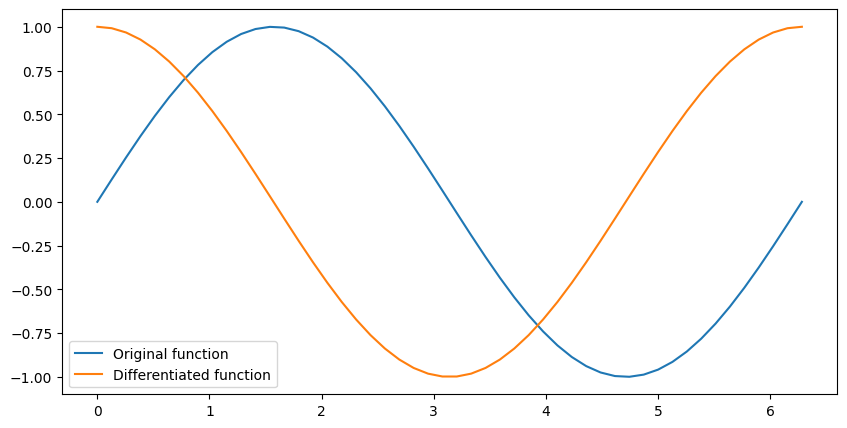

In [7]:
t = torch.linspace(0,2*torch.pi,50,requires_grad=True)
t = torch.reshape(t,(-1,1)) #The -1 reduces the dimension to a single dimension. This turns the input into a single column vector
u = torch.sin(t)
du_dt = neurodiffeq.diff(u,t)

plt.figure(figsize=(10,5))
plt.plot(t.detach().numpy(),u.detach().numpy(),label="Original function")
plt.plot(t.detach().numpy(),du_dt.detach().numpy(),label= "Differentiated function")
plt.legend()

## 1. Train for the Potential function

The problem consists on solving the differential equation using `neurodiffeq` and recover the potential $V$. We denote $x$ as the time and $y$ as the displacement to make it easier to work with the variables. $m$ is the mass of the oscillator and $k$ is the spring constant.

$$w = \sqrt \frac{k}{m}$$

$$m\ddot y + ky = 0 $$

To simplify the process we will take $m=1$

$$ \frac{d^2y}{dx^2} + \frac{dV}{dy} = 0 $$



When the potential, $V$, is unknown. The case at hand is the harmonic oscilator for which $dV/dy = ky$, where $w=2$, $k=4$, $\;\boxed{\Rightarrow V(y) = (k/2)y^2 = 2y^2}$. For this diff eq and this potential, the solution is $\boxed{y(x) = \sin(wx)}$

To deal with ODE systems, we **split it into a system of ODEs**:

$$ \frac{d(vy)}{dx} + \frac{dV}{dy} = 0 $$

$$ vy - \frac{dy}{dx} = 0 $$

**We define NNs for both systems** that take $x$ and output $y(x)$ (`net_xy`) and $x$ to output $dy/dx$ (`net_xvy`) respectively. They also define an auxiliary NN that takes $y$ and outputs $V(y)$ (`net_yV`). `net_xy` and `net_xvy` are the NNs of the solver, but `net_xvy` is internal to the system and has to be accessed via callbacks. **The interesting thing about this is that the NN is being trained on data from x and y, and manages to optimize well for V(y) as well**.

**Callback:** a feature to inject custom code into the training loop of a NN to perform various actions at different stages of the training process without modifying the core training loop.

First we define the data we want to train on 

In [8]:
## Generate data
w = 2.0
k = 4.0 

x_true = np.linspace(0, np.pi, 256)
# True data is y = sin(wx) + noise
y_true =  np.sin(w*x_true) + 0.2*np.random.randn(256)

train_gen = Generator1D(size=128,  t_min=0.0, t_max=np.pi, method='equally-spaced-noisy')
valid_gen = Generator1D(size=128, t_min=0.0, t_max=np.pi, method='equally-spaced')

The generator objects are called during training to generate data at the sampled points. We can see this using their .get_examples() method.This makes the process of generating data for ODEs much easier. There are various different types of generators in NeuroDiffEq like 1D, 2D, 3D etc.

In [9]:
train_gen.get_examples()

tensor([-7.2164e-04,  2.8212e-02,  4.1576e-02,  7.3599e-02,  9.7438e-02,
         1.1635e-01,  1.5396e-01,  1.7047e-01,  1.9831e-01,  2.1347e-01,
         2.5301e-01,  2.6805e-01,  2.9961e-01,  3.1930e-01,  3.4916e-01,
         3.7091e-01,  3.9299e-01,  4.3258e-01,  4.3890e-01,  4.6964e-01,
         4.9748e-01,  5.2322e-01,  5.5503e-01,  5.7784e-01,  5.9259e-01,
         6.1785e-01,  6.5214e-01,  6.5317e-01,  6.8268e-01,  7.1625e-01,
         7.4199e-01,  7.6902e-01,  7.8566e-01,  8.1584e-01,  8.4181e-01,
         8.6221e-01,  8.9430e-01,  9.2721e-01,  9.4498e-01,  9.6449e-01,
         9.8621e-01,  1.0181e+00,  1.0377e+00,  1.0576e+00,  1.0967e+00,
         1.1210e+00,  1.1323e+00,  1.1660e+00,  1.1844e+00,  1.2202e+00,
         1.2523e+00,  1.2533e+00,  1.3024e+00,  1.3119e+00,  1.3349e+00,
         1.3614e+00,  1.3924e+00,  1.4108e+00,  1.4387e+00,  1.4533e+00,
         1.4734e+00,  1.5025e+00,  1.5372e+00,  1.5578e+00,  1.5928e+00,
         1.6059e+00,  1.6405e+00,  1.6512e+00,  1.6

Next we define our network and system of equations

In [10]:
## x --> y --> V
# Specify the network architecture
# Each Fully Connected Neural Netwrok (FCNN) has 1 input layer, 2 hidden layers (each with 64 units), and 1 output layer
net_xy = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
) # this one takes x and outputs y(x)

net_xvy = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
) # this takes x and outputs vy=dy/dx

net_yV = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
) # This one takes y and outputs V(y)


nets = [net_xy, net_xvy] # this will be the diff eq in NN terms

def system(y, vy, x):
  # We want to solve y'' + dV/dy = 0 but we frame it as a system of first order equations
  V = net_yV(y)
  eq1 = diff(V,y) + diff(vy,x,order = 1)
  eq2 = diff(y,x) - vy
  return [eq1, eq2]


conditions = [
    IVP(t_0=0.0, u_0=0.0),
    IVP(t_0=0.0, u_0=w),
]

Now we define the Solver. This is similar to Solvers from sklearn and keras. We instantiate the solver by specifying the ODE/PDE system, initial/boundary conditions, problem domain, etc.

In [11]:
#Define Solver

class Solver_withMSE(Solver1D):
  def __init__(self, x_true = None, y_true = None, alpha_init = 1, **kwargs):
    super().__init__(**kwargs) # inherit Solver1D __init__
    self.x_true = torch.tensor(x_true, requires_grad = True).view(-1,1) #Same as the reshape shown earlier
    self.y_true = torch.tensor(y_true).view(-1,1)
    self.alpha_init = alpha_init
    self.b = -4

  # overwrite the `additional_loss` method from Solver1D to consider the mse as a term in the loss function
  def additional_loss(self, residual, funcs, coords):
    epochs = self.global_epoch
    max_epochs = self._max_local_epoch
    frac = epochs/max_epochs
    # alpha does annealing of the coefficient of mse loss becase we want the coefficient of the MSE loss to be higher when we start training
    # annealing: Allowing for the trainability to vary with the epoch No. From high variability to low.
    alpha = (self.alpha_init-1)*np.exp(self.b*frac) - (self.alpha_init-1)*np.exp(self.b)*frac + 1
    batch = [self.x_true]

    funcs = [
    self.compute_func_val(n, c, *batch) for n, c in zip(self.nets, self.conditions)
    ] # Computes the function value (the neural net outputs in this case) evaluated 
      # on the points specified by coordinates (the batch/ x_true in this case)

    loss_mse = ((funcs[0]-self.y_true)**2).mean() # simple mean squared error loss. `funcs[0]` is the y prediction. 
                                                  #`funcs[1]` would be the dy/dx prediction.
    return alpha*loss_mse
  
  # We start by emphasizing MSE at first with the high alpha to allow the network to quickly learn the true solution.
  # Alpha is lowered overtime so that MSE is deemphasized, allowing the network to focus more on satisfying the ODE.


#Allows us to use multiple optimizers
class DualOptimizer():
  def __init__(self, optimizers):
    self.optimizers = optimizers

  def step(self, closure = None):
    for opt in self.optimizers:
      opt.step(closure)

  def zero_grad(self):
    for opt in self.optimizers:
      opt.zero_grad()


opt_yx = torch.optim.Adam(set([p for net in nets for p in net.parameters()]), lr=1e-3, weight_decay=0.0001)
opt_potential = torch.optim.Adam(net_yV.parameters(), lr=1e-3)

dualoptimizer = DualOptimizer([opt_yx, opt_potential])

class DoSchedulerStep(ActionCallback):
    def __init__(self, scheduler):
        super().__init__()
        self.scheduler = scheduler

    def __call__(self, solver):
        self.scheduler.step()

class BestValidationCallback(ActionCallback):
    def __init__(self):
        super().__init__()
        self.best_potential = None

    def __call__(self, solver):
        if solver.metrics_history['train_loss'][-1] <= solver.lowest_loss:
            self.best_potential = copy.deepcopy(net_yV)  #Saves the best model of the potential


#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1200, gamma=0.95) #This changes the learning rate during the training process
#scheduler_cb = DoSchedulerStep(scheduler=scheduler)
potential_cb = BestValidationCallback()


solver = Solver_withMSE(
    x_true = x_true,
    y_true = y_true,
    alpha_init = 10,
    ode_system=system,
    conditions=conditions,
    t_min=0,
    t_max=np.pi,
    optimizer = dualoptimizer,
    train_generator=train_gen,
    valid_generator=valid_gen,
    nets=nets,
    n_batches_valid=0,
)


In [12]:
#Fitting the solver

solver.fit(max_epochs=15000, callbacks=[potential_cb])#, scheduler_cb])


Training Progress: 100%|██████████| 15000/15000 [04:49<00:00, 51.85it/s]


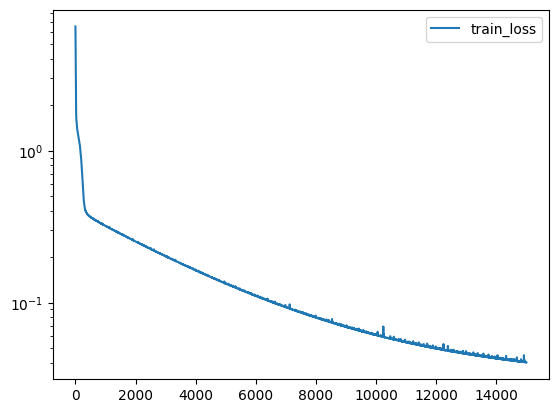

In [13]:
history = solver.metrics_history

plt.plot(history['train_loss'], label = 'train_loss')
#plt.plot(history['valid_loss'], label = 'valid_loss')
plt.legend()
plt.yscale('log')

C:\Users\nachi\AppData\Local\Temp\ipykernel_18840\4116335924.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse1 = ((ys.cpu().detach()-y_true)**2).mean()


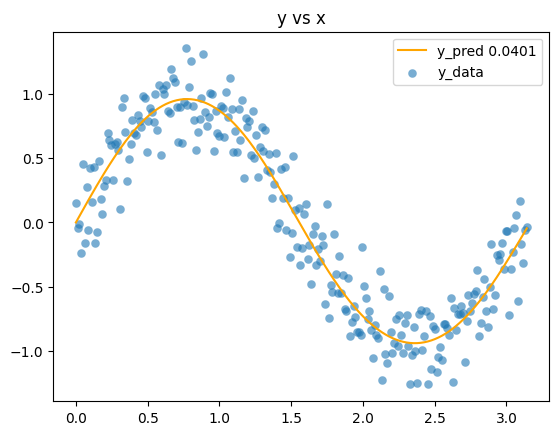

In [14]:
solution = solver.get_solution(best=True)
xs = np.linspace(0, np.pi, 256)
ys = solution(xs)[0]
mse1 = ((ys.cpu().detach()-y_true)**2).mean()

#Since ys is a tensor as it is the output of the NN, we need .cpu().detach().numpy() to turn it into an object we can pass to the ploot func

plt.plot(xs, ys.cpu().detach().numpy(), label = 'y_pred {:.4f}'.format(mse1), color = 'orange')
plt.scatter(x_true, y_true, label = 'y_data', lw = 0.1, alpha = 0.6)
plt.legend()
plt.title('y vs x')
plt.show()

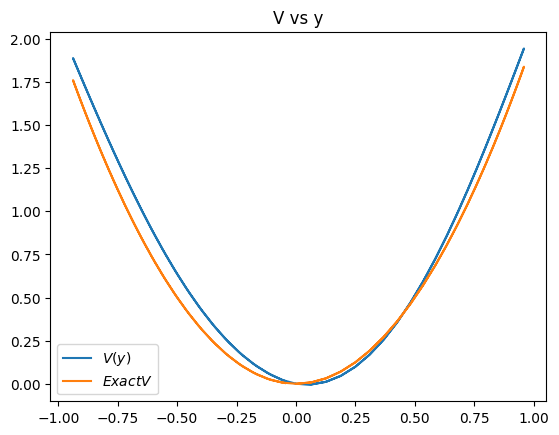

In [15]:
solution = solver.get_solution(best=True)
xs = torch.tensor(np.linspace(0, np.pi, 100)).view(-1,1)
ys = solution(xs)[0].view(-1,1)
Vs = potential_cb.best_potential(ys)
dVdy = diff(Vs, ys)
plt.plot(ys.cpu().detach().numpy(), Vs.cpu().detach().numpy() - Vs[0].item(), label = '$V(y)$')
#Exact potential = 1/2*k*y^2
plt.plot(ys.cpu().detach().numpy(), 0.5*(k)*ys.pow(2).cpu().detach().numpy(), label = '$Exact V$')
plt.legend()
plt.title('V vs y')
plt.show()

In [16]:
solution = solver.get_solution(best=True)
xs = torch.tensor(np.linspace(0, np.pi, 100)).view(-1,1)
ys = solution(xs)[0].view(-1,1)
Vs = potential_cb.best_potential(ys)


X = ys.cpu().detach().numpy()
y = Vs.cpu().detach().numpy() - Vs[0].item()

from pysr import PySRRegressor

model_SR = PySRRegressor(
    niterations=50,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)
model_SR.set_params(extra_torch_mappings = {'inv(x)': lambda x: 1/x})

c:\Users\nachi\OneDrive\Desktop\cphysics\c_physics_projects\.pysrenv\Lib\site-packages\pysr\sr.py:986: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(


PySRRegressor.equations_ = None

In [17]:
model_SR.fit(X, y)

c:\Users\nachi\OneDrive\Desktop\cphysics\c_physics_projects\.pysrenv\Lib\site-packages\pysr\sr.py:2727: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 1.730e+05
Progress: 1012 / 1550 total iterations (65.290%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.640e-01  1.594e+01  y = 1.0043
3           2.894e-01  2.360e-01  y = inv(cos(x₀))
5           2.337e-03  2.410e+00  y = (x₀ * 2.174) * x₀
6           1.681e-03  3.293e-01  y = sin(x₀) * (x₀ * 2.4718)
7           1.392e-03  1.884e-01  y = (x₀ + -0.02089) * (x₀ * 2.1746)
8           6.958e-04  6.937e-01  y = (x₀ * 2.4726) * sin(x₀ + -0.027268)
10          1.294e-04  8.412e-01  y = ((sin(x₀ + -0.1651) + 0.095625) * x₀) * 2.5025
12          8.807e-05  1.922e-01  y = ((sin(x₀ + -0.1636) + 0.094637) * (x₀ * 2.5217)) + -0....
                                      011547
13          2.767e-05  1.158e+00  y = ((x₀ + sin(sin(x₀ + -0.35639) + 0.19619)

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          1.0043316   
	1         0.235993                                       inv(cos(x0))   
	2         2.409591                               (x0 * 2.173958) * x0   
	3         0.329301                         sin(x0) * (x0 * 2.4717834)   
	4         0.188434             ((x0 * 2.1746137) + -0.045432426) * x0   
	5         0.693736          (x0 * sin(x0 + -0.027267957)) * 2.4726353   
	6         0.841245  ((sin(x0 + -0.16509524) + 0.09562509) * x0) * ...   
	7         0.198168  ((sin(x0 + -0.17835964) + 0.06774776) * (x0 + ...   
	8         1.232252  (x0 * (x0 + (sin(sin(x0) + -0.4796029) + 0.312...   
	9         0.182942  x0 * ((x0 + sin(sin(sin(x0 + -0.28456664)) + 0...   
	10        0.049597  (x0 * (sin((sin(x0 + -0.35141096) * 1.090756) ...   
	11        0.012046  -0.0029677683 + ((sin(sin((x0 * 1.0721833) + -...   
	12        0.715804  sin(x0) + (x0 * (((x0 + -0.5837537) + sin(sin(...   
	13        0.073637  sin(x0 * 1.1320394) + ((x0 * (sin(sin((x0 * 1....   
	14  >>>>  0.680282  (((x0 * 2.6381652) + -0.22302972) * sin(x0)) +...   
	15        0.029664  (((-0.2215224 + x0) + (x0 * 1.6363513)) * sin(...   
	16        0.014449  ((x0 + ((x0 * 1.6362672) + -0.22202332)) * sin...   
	17        0.068955  (((sin(sin(x0 + (x0 + 0.09124434))) * x0) * 0....   
	18        0.030427  (sin(x0) * (((x0 + x0) * 1.325756) + -0.212591...   
	19        0.003084  (((x0 + -0.73289317) * sin(sin(sin((sin(x0 * 0...   
	
	        loss  complexity  
	0   0.464016           1  
	1   0.289436           3  
	2   0.002337           5  
	3   0.001681           6  
	4   0.001392           7  
	5   0.000696           8  
	6   0.000129          10  
	7   0.000087          12  
	8   0.000025          13  
	9   0.000021          14  
	10  0.000020          15  
	11  0.000020          17  
	12  0.000010          18  
	13  0.000008          20  
	14  0.000002          22  
	15  0.000002          24  
	16  0.000002          25  
	17  0.000002          26  
	18  0.000002          29  
	19  0.000002          30  
]

  - outputs\20241202_195320_I8gqmu\hall_of_fame.csv


## Train PINN on candidate potentials without data then validate with data

Training Progress: 100%|██████████| 2000/2000 [00:20<00:00, 99.70it/s] 


Candidate potential : 1.00433160000000 MSE with data : 15.6371254


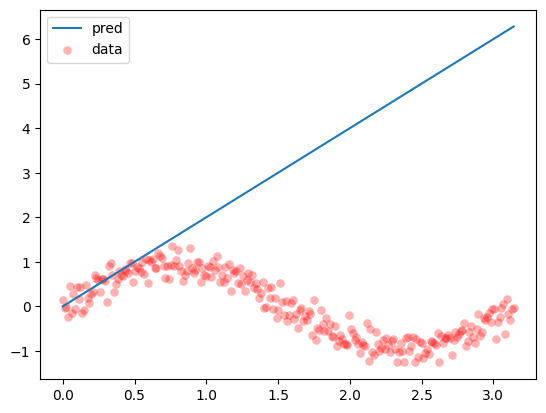

Training Progress: 100%|██████████| 2000/2000 [00:21<00:00, 92.65it/s]


Candidate potential : 1/cos(x0) MSE with data : 29.6158422


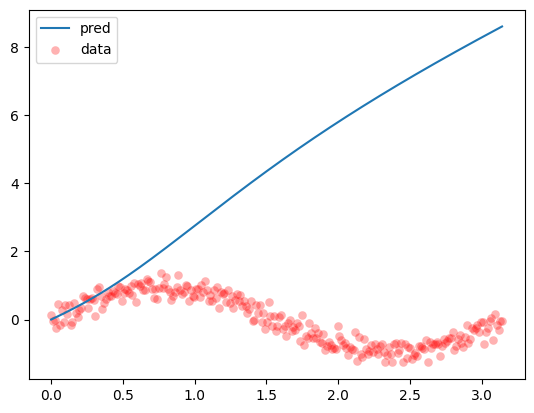

Training Progress: 100%|██████████| 2000/2000 [00:22<00:00, 90.31it/s]


Candidate potential : x0*2.173958*x0 MSE with data : 0.0514072


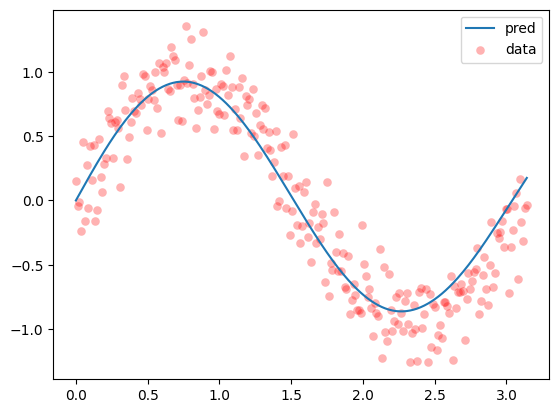

Training Progress: 100%|██████████| 2000/2000 [00:22<00:00, 87.21it/s]


Candidate potential : sin(x0)*x0*2.4717834 MSE with data : 3.9614314


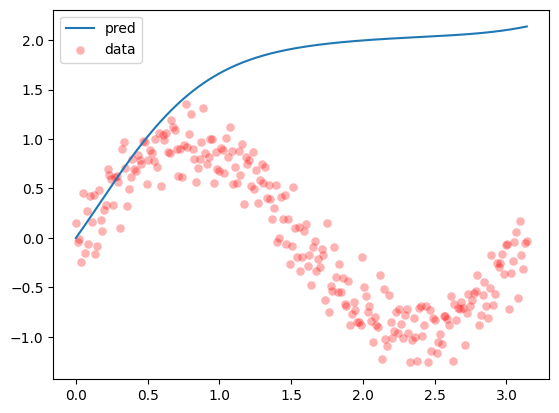

Training Progress: 100%|██████████| 2000/2000 [00:24<00:00, 83.31it/s]


Candidate potential : x0*(x0*2.1746137 - 0.045432426) MSE with data : 0.0521873


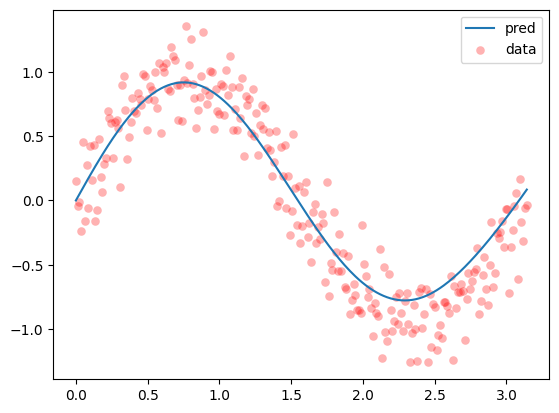

Training Progress: 100%|██████████| 2000/2000 [00:26<00:00, 74.68it/s]


Candidate potential : x0*sin(x0 - 0.027267957)*2.4726353 MSE with data : 0.0446838


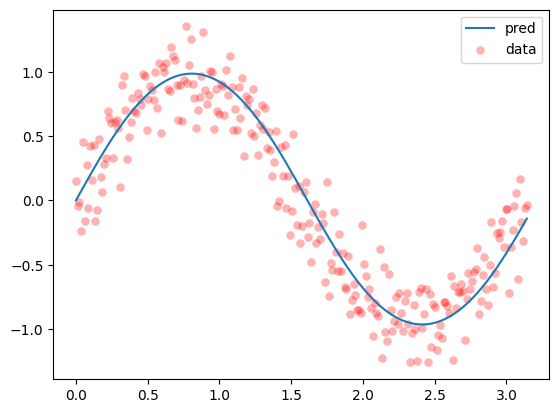

Training Progress: 100%|██████████| 2000/2000 [00:25<00:00, 77.04it/s]


Candidate potential : (sin(x0 - 0.16509524) + 0.09562509)*x0*2.5024729 MSE with data : 0.0429823


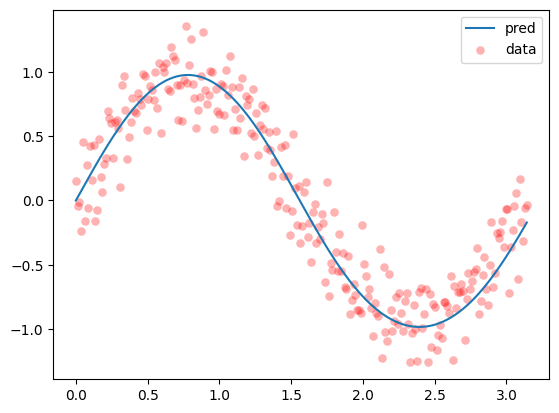

LOWEST MSE OBTAINED BY:  (sin(x0 - 0.16509524) + 0.09562509)*x0*2.5024729  =  0.04298225853664948


In [18]:
top7_candidates = model_SR.pytorch(index = list(range(7))) # ?? this retrieves a torch-like symbolic expression that can be used to evaluate tensors
min_loss = 1e5 # this is just initializing the min_loss to a large value. You could do np.inf
min_loss_cand = None
for cand in top7_candidates:
  net_xy_cand = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
  )

  def system_cand(y, x):
    V = cand(y).view(-1,1) # calculating the potential given by symbolic expression (that is trainable??)
    if V.shape == torch.Size([1, 1]):
      V = V * torch.ones_like(y)
    eq1 = diff(V,y) + diff(y,x,order = 2) # this is the whole DE of 2nd order
    return [eq1]

  nets_cand = [net_xy_cand]
  opt_yx_cand = torch.optim.Adam(set([p for net in nets_cand for p in net.parameters()]), lr=1e-3)
  conditions_cand = [
    IVP(t_0=0.0, u_0=0.0, u_0_prime = w),
  ]

  solver_cand = Solver1D(
    ode_system=system_cand,
    conditions=conditions_cand,
    t_min=0,
    t_max=np.pi,
    optimizer = opt_yx_cand,
    train_generator=train_gen,
    valid_generator=valid_gen,
    nets=nets_cand,
    n_batches_valid=0,
  )

  solver_cand.fit(max_epochs = 2000)
  solution_cand = solver_cand.get_solution(best = True)
  y_pred = solution_cand(x_true).cpu().detach().numpy()
  mse = ((y_pred - y_true)**2).mean()
  if mse < min_loss:
    min_loss = mse
    min_loss_cand = cand
  print('Candidate potential :',cand._expression_string, 'MSE with data : {:.7f}'.format(mse))
  plt.plot(x_true, y_pred, label = 'pred')
  plt.scatter(x_true, y_true, label = 'data', color = 'red', alpha = 0.3, lw = 0.1)
  plt.legend()
  plt.show()
  print('================================================')

print('LOWEST MSE OBTAINED BY: ',cand._expression_string, ' = ', min_loss)
print('================================================')

## 3. Finetuning candidates on the trained net

parameters before training:  [('_node._value', Parameter containing:
tensor(1.0043, requires_grad=True))]
expression before training:  1.00433160000000


Training Progress: 100%|██████████| 2000/2000 [00:25<00:00, 78.17it/s]


parameters after training:  [('_node._value', Parameter containing:
tensor(1.0043, requires_grad=True))]
Candidate potential : 1.00433160000000 MSE : 0.4407460 Lowest Loss : 1.9799381


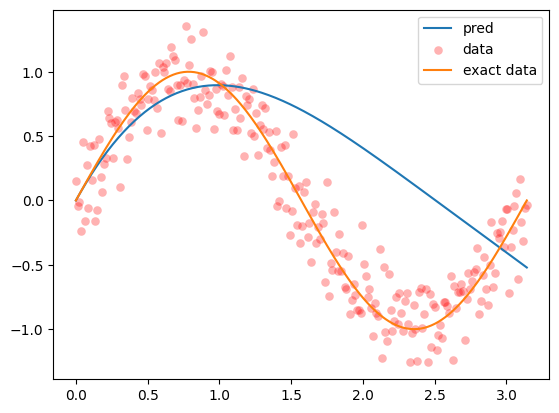

parameters before training:  []
expression before training:  1/cos(x0)


Training Progress: 100%|██████████| 2000/2000 [00:27<00:00, 73.71it/s]


parameters after training:  []
Candidate potential : 1/cos(x0) MSE : 89.0265663 Lowest Loss : 2368.0521697


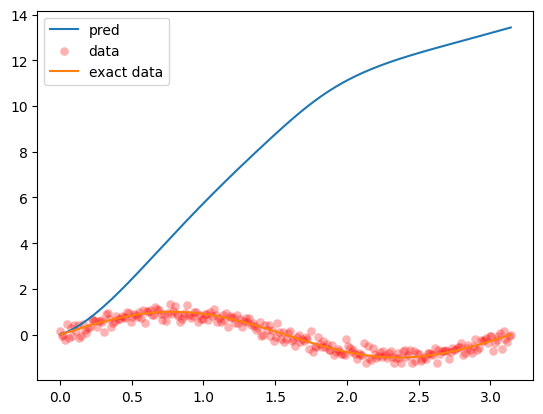

parameters before training:  [('_node._args.1._value', Parameter containing:
tensor(2.1740, requires_grad=True))]
expression before training:  x0*2.173958*x0


Training Progress: 100%|██████████| 2000/2000 [00:32<00:00, 61.83it/s]


parameters after training:  [('_node._args.1._value', Parameter containing:
tensor(1.9768, requires_grad=True))]
Candidate potential : x0*2.173958*x0 MSE : 0.0415326 Lowest Loss : 0.0441686


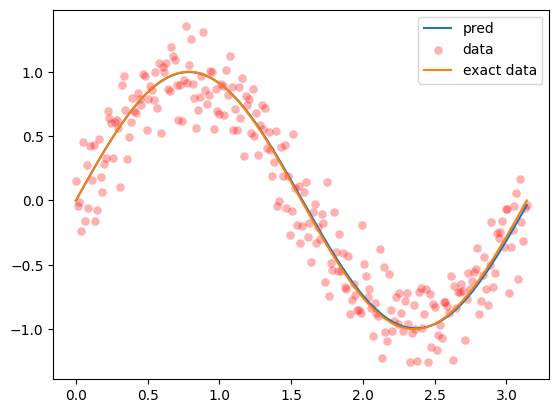

parameters before training:  [('_node._args.2._value', Parameter containing:
tensor(2.4718, requires_grad=True))]
expression before training:  sin(x0)*x0*2.4717834


Training Progress: 100%|██████████| 2000/2000 [00:34<00:00, 58.15it/s]


parameters after training:  [('_node._args.2._value', Parameter containing:
tensor(2.3797, requires_grad=True))]
Candidate potential : sin(x0)*x0*2.4717834 MSE : 0.0494660 Lowest Loss : 0.0586966


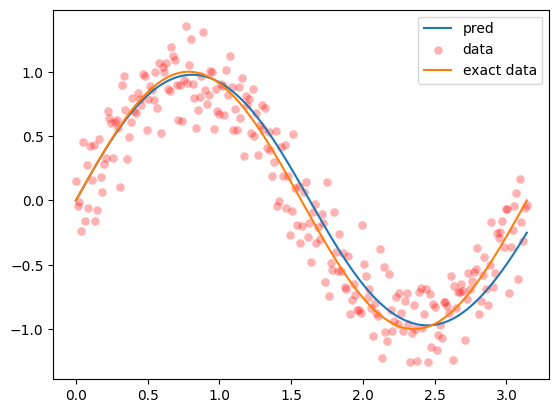

parameters before training:  [('_node._args.0._args.0._args.1._value', Parameter containing:
tensor(2.1746, requires_grad=True)), ('_node._args.0._args.1._value', Parameter containing:
tensor(-0.0454, requires_grad=True))]
expression before training:  x0*(x0*2.1746137 - 0.045432426)


Training Progress: 100%|██████████| 2000/2000 [00:34<00:00, 58.33it/s]


parameters after training:  [('_node._args.0._args.0._args.1._value', Parameter containing:
tensor(1.9896, requires_grad=True)), ('_node._args.0._args.1._value', Parameter containing:
tensor(-0.0314, requires_grad=True))]
Candidate potential : x0*(x0*2.1746137 - 0.045432426) MSE : 0.0416179 Lowest Loss : 0.0442545


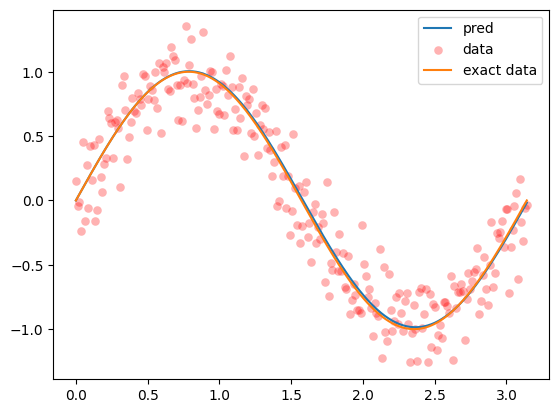

parameters before training:  [('_node._args.1._args.0._args.1._value', Parameter containing:
tensor(-0.0273, requires_grad=True)), ('_node._args.2._value', Parameter containing:
tensor(2.4726, requires_grad=True))]
expression before training:  x0*sin(x0 - 0.027267957)*2.4726353


Training Progress: 100%|██████████| 2000/2000 [00:32<00:00, 62.49it/s]


parameters after training:  [('_node._args.1._args.0._args.1._value', Parameter containing:
tensor(0.3121, requires_grad=True)), ('_node._args.2._value', Parameter containing:
tensor(2.5135, requires_grad=True))]
Candidate potential : x0*sin(x0 - 0.027267957)*2.4726353 MSE : 0.0489168 Lowest Loss : 0.0513994


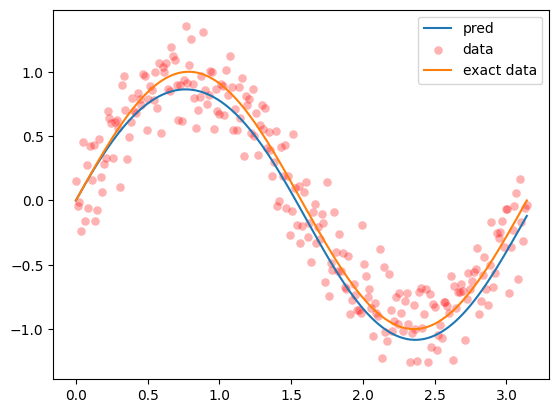

parameters before training:  [('_node._args.0._args.0._args.0._args.1._value', Parameter containing:
tensor(-0.1651, requires_grad=True)), ('_node._args.0._args.1._value', Parameter containing:
tensor(0.0956, requires_grad=True)), ('_node._args.2._value', Parameter containing:
tensor(2.5025, requires_grad=True))]
expression before training:  (sin(x0 - 0.16509524) + 0.09562509)*x0*2.5024729


Training Progress: 100%|██████████| 2000/2000 [00:33<00:00, 59.33it/s]


parameters after training:  [('_node._args.0._args.0._args.0._args.1._value', Parameter containing:
tensor(1.3867, requires_grad=True)), ('_node._args.0._args.1._value', Parameter containing:
tensor(-0.0612, requires_grad=True)), ('_node._args.2._value', Parameter containing:
tensor(2.9538, requires_grad=True))]
Candidate potential : (sin(x0 - 0.16509524) + 0.09562509)*x0*2.5024729 MSE : 0.4360579 Lowest Loss : 0.4860991


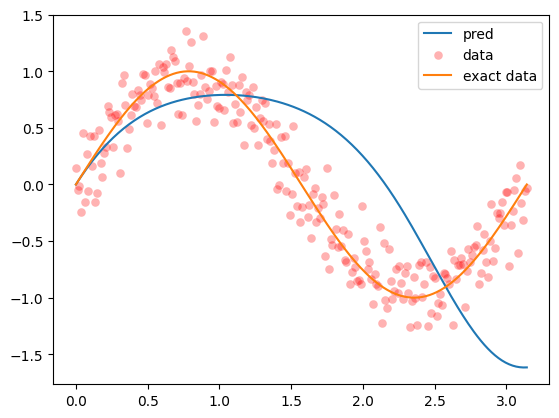

In [ ]:
top7_candidates = model_SR.pytorch(index = list(range(7)))

for cand in top7_candidates:
  net_xy_cand = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
  )

  def system_cand(y, x):
    V = cand(y).view(-1,1)
    if V.shape == torch.Size([1, 1]):
      V = V * torch.ones_like(y)
    eq1 = diff(V,y) + diff(y,x,order = 2)
    return [eq1]

  #print('parameters before training: ',list(cand.named_parameters()))
  #print('expression before training: ',cand._expression_string)s

  nets_cand = [copy.deepcopy(net_xy)] # changed
  opt_yx_cand = torch.optim.Adam(set([p for net in nets_cand for p in net.parameters()]), lr=1e-3, weight_decay = 0.0001)
  conditions_cand = [
    IVP(t_0=0.0, u_0=0.0, u_0_prime = 2.0),
  ]
  if len(list(cand.parameters()))>0:
    opt_cand = torch.optim.Adam(cand.parameters(), lr=1e-2)
    dualoptimizer_cand = DualOptimizer([opt_yx_cand, opt_cand])
    opt_final = dualoptimizer_cand
  else:
    opt_final = opt_yx_cand

  solver_cand = Solver_withMSE(
    x_true = x_true,
    y_true = y_true,
    ode_system=system_cand,
    conditions=conditions_cand,
    t_min=0,
    t_max=np.pi,
    optimizer = opt_final,
    train_generator=train_gen,
    valid_generator=valid_gen,
    nets=nets_cand,
    n_batches_valid=0,
  )
  solver_cand.fit(max_epochs = 2000)
  print('parameters after training: ',list(cand.named_parameters()))
  solution_cand = solver_cand.get_solution(best = True)
  y_pred = solution_cand(x_true).cpu().detach().numpy()
  print('Candidate potential :',cand._expression_string, 'MSE : {:.7f}'.format(((y_pred - y_true)**2).mean()), 'Lowest Loss : {:.7f}'.format(solver_cand.lowest_loss))#, solver_cand.lowest_loss)
  plt.plot(x_true, y_pred, label = 'pred')
  plt.scatter(x_true, y_true, label = 'data', color = 'red', alpha = 0.3, lw = 0.1)
  plt.plot(x_true, np.sin(2*x_true), label = 'exact data')
  plt.legend()
  plt.show()
  print('================================================')